In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense, Dropout
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                     parse_dates=True, index_col="timestamp")
# raw_dt = pd.read_csv(datafile_path)
data.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


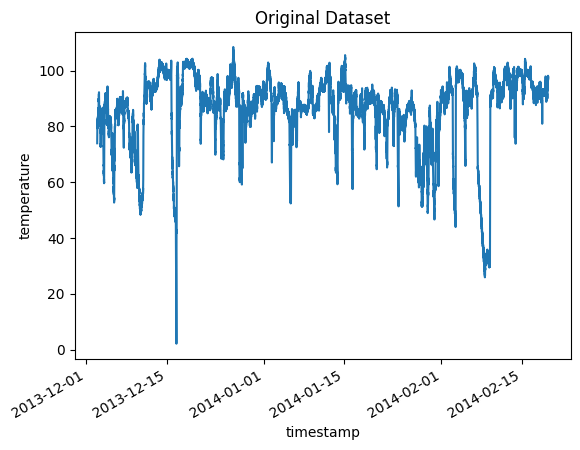

In [3]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.ylabel("temperature")
plt.title("Original Dataset")
plt.show()

In [4]:
#data['label'] = 0
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [5]:
# for i in range(len(instances)): 
#     start = pd.to_datetime(instances[i][0])
#     end = pd.to_datetime(instances[i][1])
#     data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [6]:
data_w_ts=data.copy()
data_w_ts

,value,label
timestamp,,
2013-12-02 21:15:00,73.967322,0
2013-12-02 21:20:00,74.935882,0
2013-12-02 21:25:00,76.124162,0
2013-12-02 21:30:00,78.140707,0
2013-12-02 21:35:00,79.329836,0
...,...,...
2014-02-19 15:05:00,98.185415,0
2014-02-19 15:10:00,97.804168,0
2014-02-19 15:15:00,97.135468,0


In [7]:
# Splitting to train and test
test_ratio =0.1#0.3
start =0        # int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [8]:
scaler = preprocessing.StandardScaler().fit(tr_data["value"].values.reshape(-1, 1))
tr_data_scaled = tr_data.copy()
tr_data_scaled['value'] = scaler.transform(tr_data['value'].values.reshape(-1, 1))
tst_data_scaled = tst_data.copy()
tst_data_scaled['value'] = scaler.transform(tst_data["value"].values.reshape(-1, 1))

In [9]:
tr_data_scaled

,value,label
timestamp,,
2013-12-02 21:15:00,-0.777622,0
2013-12-02 21:20:00,-0.708697,0
2013-12-02 21:25:00,-0.624137,0
2013-12-02 21:30:00,-0.480637,0
2013-12-02 21:35:00,-0.396016,0
...,...,...
2014-02-11 17:55:00,0.418282,0
2014-02-11 18:00:00,0.444943,0
2014-02-11 18:05:00,0.547397,0


In [10]:
train = tr_data_scaled[tr_data_scaled.label == 0]
train= train.drop(columns=['label'])
train

,value
timestamp,
2013-12-02 21:15:00,-0.777622
2013-12-02 21:20:00,-0.708697
2013-12-02 21:25:00,-0.624137
2013-12-02 21:30:00,-0.480637
2013-12-02 21:35:00,-0.396016
...,...
2014-02-11 17:55:00,0.418282
2014-02-11 18:00:00,0.444943
2014-02-11 18:05:00,0.547397


In [11]:
labels_of_test = tst_data_scaled['label'].tolist()
test = tst_data_scaled.drop(columns=['label'])

In [12]:
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [13]:
train= create_sequences(train['value'], 500)

In [14]:
#Converting df to arrays
train= np.asarray(train).astype(np.float32)
test= np.asarray(test).astype(np.float32)
print("Train shape: ", train.shape) 

Train shape:  (19926, 500)


In [15]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [16]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [17]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + 0.05*kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [18]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 4)

In [19]:
print(input_shape)

(500,)


In [20]:
#Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dropout(0.2)(x)  # Add dropout layer with a dropout rate of 0.2
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

In [21]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(0.2)(x)  # Add dropout layer with a dropout rate of 0.2
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │        31,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       125,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,000 (613.28 KB)

 Trainable params: 157,000 (613.28 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dropout(0.2)(x)  # Add dropout to the encoder
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(0.2)(x)  # Add dropout to the decoder
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()

Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 250)       │    125,250 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 125)       │    188,000 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 250)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 500)       │    157,000 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 125)       │     31,375 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 125)       │     31,375 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 500)       │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 345,000 (1.32 MB)

 Trainable params: 345,000 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:

# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Epoch 1/1000


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 43099.7383 - val_loss: 156235.2812
Epoch 2/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 30041.7031 - val_loss: 153948.2656
Epoch 3/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27623.8262 - val_loss: 151809.0938
Epoch 4/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25951.9883 - val_loss: 150670.1562
Epoch 5/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25856.0234 - val_loss: 150289.4531
Epoch 6/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25608.7402 - val_loss: 149734.7344
Epoch 7/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25610.4414 - val_loss: 149377.5000
Epoch 8/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 24989.0000 - val_loss: 148963.2812
Epoch 9/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25223.1875 - val_loss: 148786.2344
Epoch 10/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 23702.2422 - val_loss: 148441.2969
Epoch 11/1000
125/125 ━━━━━━━━━━━━━━━━━━━━

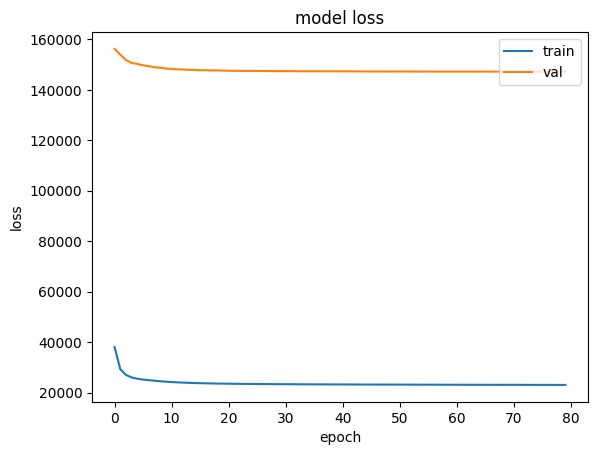

In [24]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [25]:
train_pred = vae_model.predict(train)[0]
print(train_pred.shape)

623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(19926, 500)


In [26]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
# print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

# error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.5880855917930603
median error 0.3341268301010132
99Q: 3.2625855207443237


(array([3627., 2568., 2401., 1406., 1183.,  863.,  695.,  908.,  856.,
         268.,  580.,  499.,  129.,  170.,  139.,  189.,  573.,  306.,
         147.,  189.,  295.,  387.,  184.,  157.,  152.,  332.,   21.,
          22.,   21.,   21.,   21.,   21.,   22.,   21.,   22.,   23.,
          24.,   24.,   24.,   26.,   27.,   30.,   31.,   34.,   37.,
          40.,   43.,   47.,   53.,   68.]),
 array([0.05736659, 0.12662621, 0.19588584, 0.26514545, 0.33440506,
        0.40366468, 0.47292432, 0.54218394, 0.61144358, 0.68070316,
        0.74996281, 0.81922239, 0.88848203, 0.95774168, 1.02700126,
        1.09626091, 1.16552055, 1.23478007, 1.30403972, 1.37329936,
        1.442559  , 1.51181865, 1.58107829, 1.65033782, 1.71959746,
        1.7888571 , 1.85811675, 1.92737639, 1.99663591, 2.06589556,
        2.1351552 , 2.20441484, 2.27367449, 2.34293413, 2.41219378,
        2.48145318, 2.55071282, 2.61997247, 2.68923211, 2.75849175,
        2.8277514 , 2.89701104, 2.96627069, 3.03553033, 

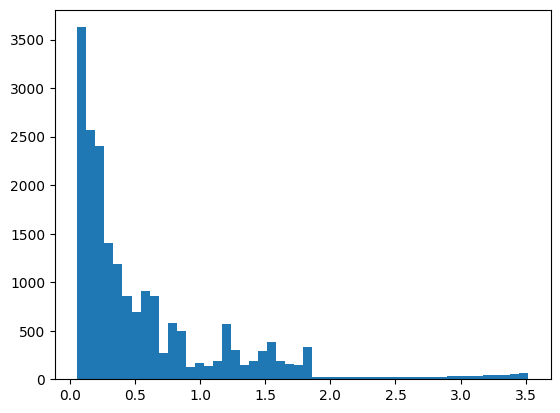

In [27]:
plt.hist(mae_vector, bins=50)

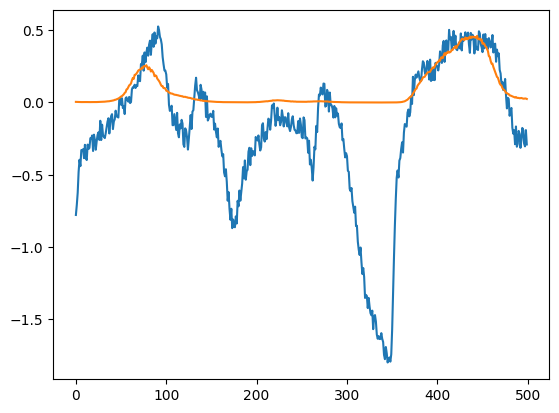

In [28]:
plt.plot(train[0])
plt.plot(train_pred[0])
plt.show()

In [29]:
error_thresh = np.max(mae_vector) 
print(f'setting threshold on {error_thresh} ')

setting threshold on 3.5203475952148438 


In [30]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

1.0


In [31]:
# Create sequences from test values.
test = create_sequences(test.values, 500)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae_model.predict(test)
#test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
mae_vector_test = get_error_term(pred, test, _rmse=True)
test_mae_loss = mae_vector_test.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > error_thresh
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

ValueError: Invalid dtype: datetime64[ns]

(array([ 32.,  60.,  39.,  37., 180.,  84.,  63.,  89., 172., 515., 316.,
        318., 376., 519., 277., 385., 277., 265., 438., 470., 476., 401.,
        268., 120.,  58.,  22.,  27.,  31.,  19.,  12.,  17.,  10.,   4.,
          1.,   0.,   0.,   0.,  14.,  21.,  17.,  17.,  20.,  40.,  84.,
         87.,  64.,  23.,  16.,  15.,  13.]),
 array([0.26834872, 0.2831862 , 0.29802367, 0.31286114, 0.32769862,
        0.34253609, 0.35737357, 0.37221104, 0.38704851, 0.40188599,
        0.41672346, 0.43156093, 0.44639841, 0.46123588, 0.47607335,
        0.49091083, 0.50574833, 0.52058578, 0.53542328, 0.55026072,
        0.56509823, 0.57993567, 0.59477317, 0.60961062, 0.62444812,
        0.63928556, 0.65412307, 0.66896051, 0.68379802, 0.69863546,
        0.71347296, 0.72831041, 0.74314791, 0.75798535, 0.77282286,
        0.7876603 , 0.8024978 , 0.81733525, 0.83217275, 0.8470102 ,
        0.8618477 , 0.87668514, 0.89152265, 0.90636009, 0.92119759,
        0.93603504, 0.95087254, 0.96570998, 0.

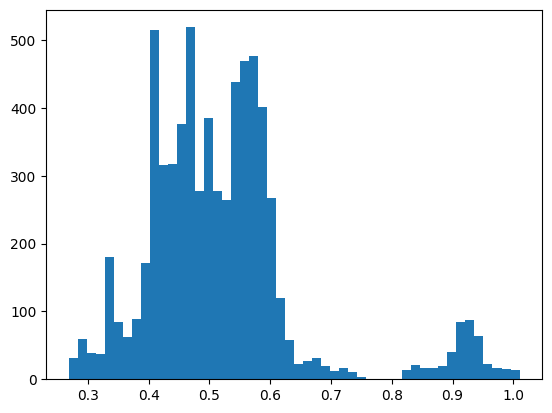

In [ ]:
plt.hist(mae_vector_test, bins=50)

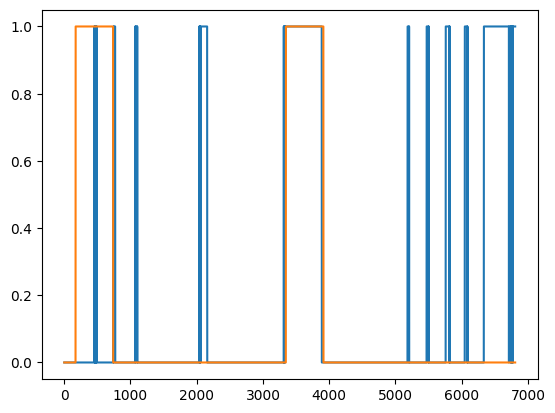

In [ ]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [ ]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.90      0.86      0.88      5675
        True       0.42      0.50      0.46      1134

    accuracy                           0.80      6809
   macro avg       0.66      0.68      0.67      6809
weighted avg       0.82      0.80      0.81      6809



In [ ]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]
tst_data

C:\Users\99anj\AppData\Local\Temp\ipykernel_32972\2082240037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_32972\2082240037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


,timestamp,value,label,anomaly
15886,2014-01-27 00:05:00,88.482330,1,False
15887,2014-01-27 00:10:00,86.688731,1,False
15888,2014-01-27 00:15:00,88.053503,1,False
15889,2014-01-27 00:20:00,88.442419,1,False
15890,2014-01-27 00:25:00,87.257083,1,False
...,...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1,True
22691,2014-02-19 15:10:00,97.804168,1,True
22692,2014-02-19 15:15:00,97.135468,1,True
22693,2014-02-19 15:20:00,98.056852,1,True


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

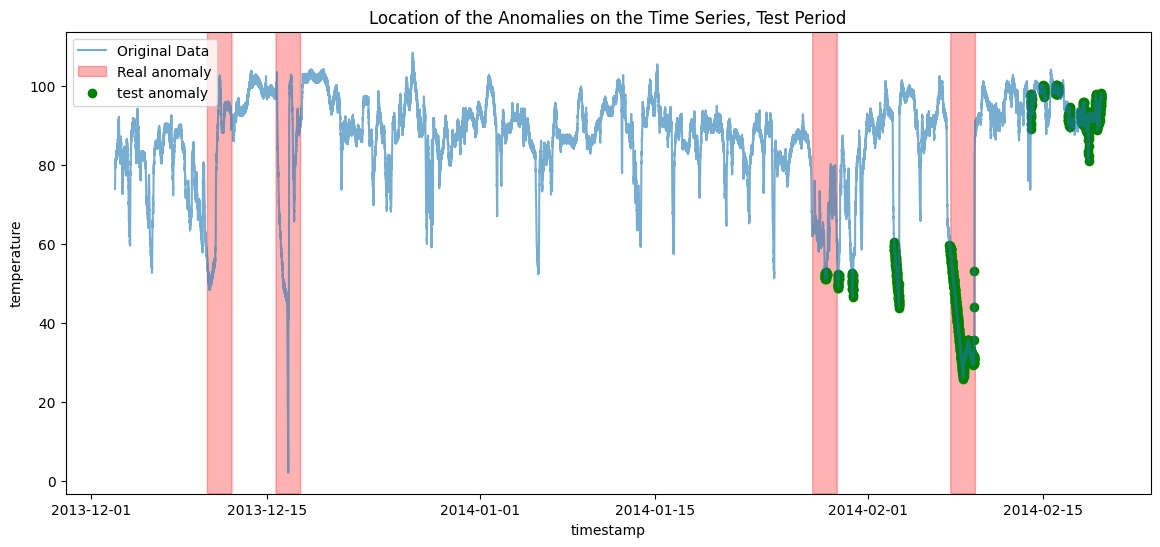

In [ ]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=np.logical_not(data_w_ts['label']), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")

In [ ]:
encoded = encoder.predict(test)

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transform = pca.fit_transform(encoded)

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

ValueError: All arrays must be of the same length

<Figure size 1200x1000 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=10, hue=labels_of_test)
plt.grid()
plt.show()